In [1]:
!pip install -U langgraph langchain-groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.6
    Uninstalling langchain-text-splitters-0.3.6:
      Successfully uninstalled langchain-text-splitters-0.3.6
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.20
    Uninstalling langchain-0.3.20:
      Successfully uninstalled langchain-0.3.20


In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


In [3]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [4]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [6]:
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatGroq(model="qwen-2.5-32b")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [20]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [21]:
graph_builder.add_conditional_edges("chatbot", tools_condition)

ValueError: Branch with name `tools_condition` already exists for node `chatbot`

In [22]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [23]:
graph = graph_builder.compile(checkpointer=memory)

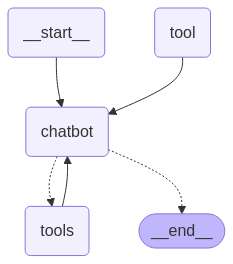

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Run this below block of code if you want to remove Node**

In [31]:
graph_builder.edges.remove(("tool","chatbot"))

In [34]:
graph_builder.nodes.pop("tool")

StateNodeSpec(runnable=tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}, tool_to_state_args={'tavily_search_results_json': {}}, tool_to_store_arg={'tavily_search_results_json': None}, handle_tool_errors=True, messages_key='messages'), metadata=None, input=<class '__main__.State'>, retry_policy=None, ends=())

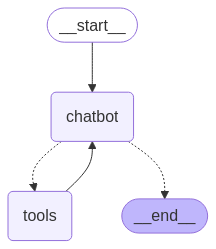

In [35]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:
config = {"configurable": {"thread_id": "1"}}

In [37]:
user_input = "Hi,There!, My Name is Sainath"

events = graph.stream(
    {"messages":[{"role":"user","content":user_input}]},
    config,
    stream_mode = "values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi,There!, My Name is Sainath
================================== Ai Message ==================================

Hello Sainath! It's nice to meet you. How can I assist you today?


In [38]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, Sainath, I remember your name. How can I assist you further?


In [39]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course! You're the user I've been assisting. Could you remind me of your name though? I want to make sure I have it right.
